# Unsupervised Model Analysis

## Import library

In [813]:
import numpy as np
import pickle, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, cross_val_predict

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.kernel_approximation import Nystroem
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
from colorsetup import colors, palette

# from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

## Read the data
Here we introduce the 200+ Financial Indicators of US stocks (2014-2018) data as the raw dataset.

In [814]:
path = './data/200+ Financial Indicators of US stocks (2014-2018)/'
df1 = pd.read_csv(path + '2018_Financial_Data.csv')

In [815]:
# Check each file's schema
print(df1.shape)

(4392, 225)


## Check the files
Here we check the data types, investigate the missing data and prepare necessary encoding.

In [816]:
# Check data types
def checkDataTypes(df):
    i = 0
    for type in df.dtypes:
        if ((type != np.float) & (type != np.int32) & (type != np.int64)):
            print('Column: ' + df.columns[i] + ' = ' +  str(type))
        i+=1

In [817]:
checkDataTypes(df1)

Column: Unnamed: 0 = object
Column: Sector = object


In [818]:
# Rename the first column
df1.rename(columns={'Unnamed: 0': 'Stock'}, inplace=True)

In [819]:
df1_backup = df1.copy()
df1.drop(columns=['Sector'], inplace=True)
print(df1.shape)

(4392, 224)


In [820]:
# Add Year column
df1['Data Year'] = 2018
# Rename Price VAR column
df1.rename(columns={'2019 PRICE VAR [%]':'Next Year VAR%'}, inplace=True)

In [821]:
print('2018_Financial_Data.csv shape: {}'.format(df1.shape))

2018_Financial_Data.csv shape: (4392, 225)


In [822]:
stock_data = df1
print(stock_data.shape)
print('Total rows are equal? ' + str(stock_data.shape[0] == df1.shape[0]))

(4392, 225)
Total rows are equal? True


In [823]:
# Re-order data columns
columns = stock_data.columns.to_list()
new_columns = []
new_columns.append(columns[-1])
new_columns.append(columns[0])
new_columns.append(columns[-2])
new_columns.append(columns[-3])
new_columns.extend(columns[1:-3])

stock_data = stock_data[new_columns]
stock_data

,Data Year,Stock,Class,Next Year VAR%,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,...,10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth
0,2018,CMCSA,1,32.794573,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,...,0.2558,0.1865,0.2348,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308
1,2018,KMI,1,40.588068,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,...,0.0000,-0.1421,-0.2785,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265
2,2018,INTC,1,30.295514,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,...,0.0815,0.0592,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942
3,2018,MU,1,64.213737,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,...,0.0000,0.0000,0.0000,0.4573,0.1511,0.2275,0.6395,-0.5841,0.1738,0.0942
4,2018,GE,1,44.757840,1.216150e+11,0.0285,9.546100e+10,2.615400e+10,0.000000e+00,1.811100e+10,...,-0.1139,-0.1408,-0.2619,-0.2781,-0.2892,-0.1575,-0.4487,-0.2297,0.0000,0.0308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4387,2018,YRIV,0,-90.962099,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,0.000000e+00,3.755251e+06,...,NaN,NaN,0.0000,0.0000,0.0000,-0.0508,-0.1409,-0.0152,0.0000,-0.2602
4388,2018,YTEN,0,-77.922077,5.560000e+05,-0.4110,0.000000e+00,5.560000e+05,4.759000e+06,5.071000e+06,...,0.0000,0.0000,0.0000,0.3445,0.0000,-0.2323,-0.8602,0.0000,0.0352,-0.0993
4389,2018,ZKIN,0,-17.834400,5.488438e+07,0.2210,3.659379e+07,1.829059e+07,1.652633e+06,7.020320e+06,...,NaN,NaN,0.0000,0.1605,0.7706,0.2489,0.4074,-0.0968,0.2415,0.8987
4390,2018,ZOM,0,-73.520000,0.000000e+00,0.0000,0.000000e+00,0.000000e+00,1.031715e+07,4.521349e+06,...,NaN,NaN,NaN,0.8980,0.0000,0.1568,-0.2200,0.0000,2.7499,0.1457


## Data Exploratory
Here we start to analyze the dataset, extract the business data and deal with missing values as well as outliers.

In [824]:
stock_data = stock_data.replace(r'\\n',' ', regex=True)

In [825]:
s = stock_data.corr()['Class'].sort_values(ascending=False)
s.describe()
# s.plot(kind='bar', figsize=(100,10))

count    222.000000
mean       0.032000
std        0.089785
min       -0.097506
25%       -0.008194
50%        0.015955
75%        0.051574
max        1.000000
Name: Class, dtype: float64

<AxesSubplot:>

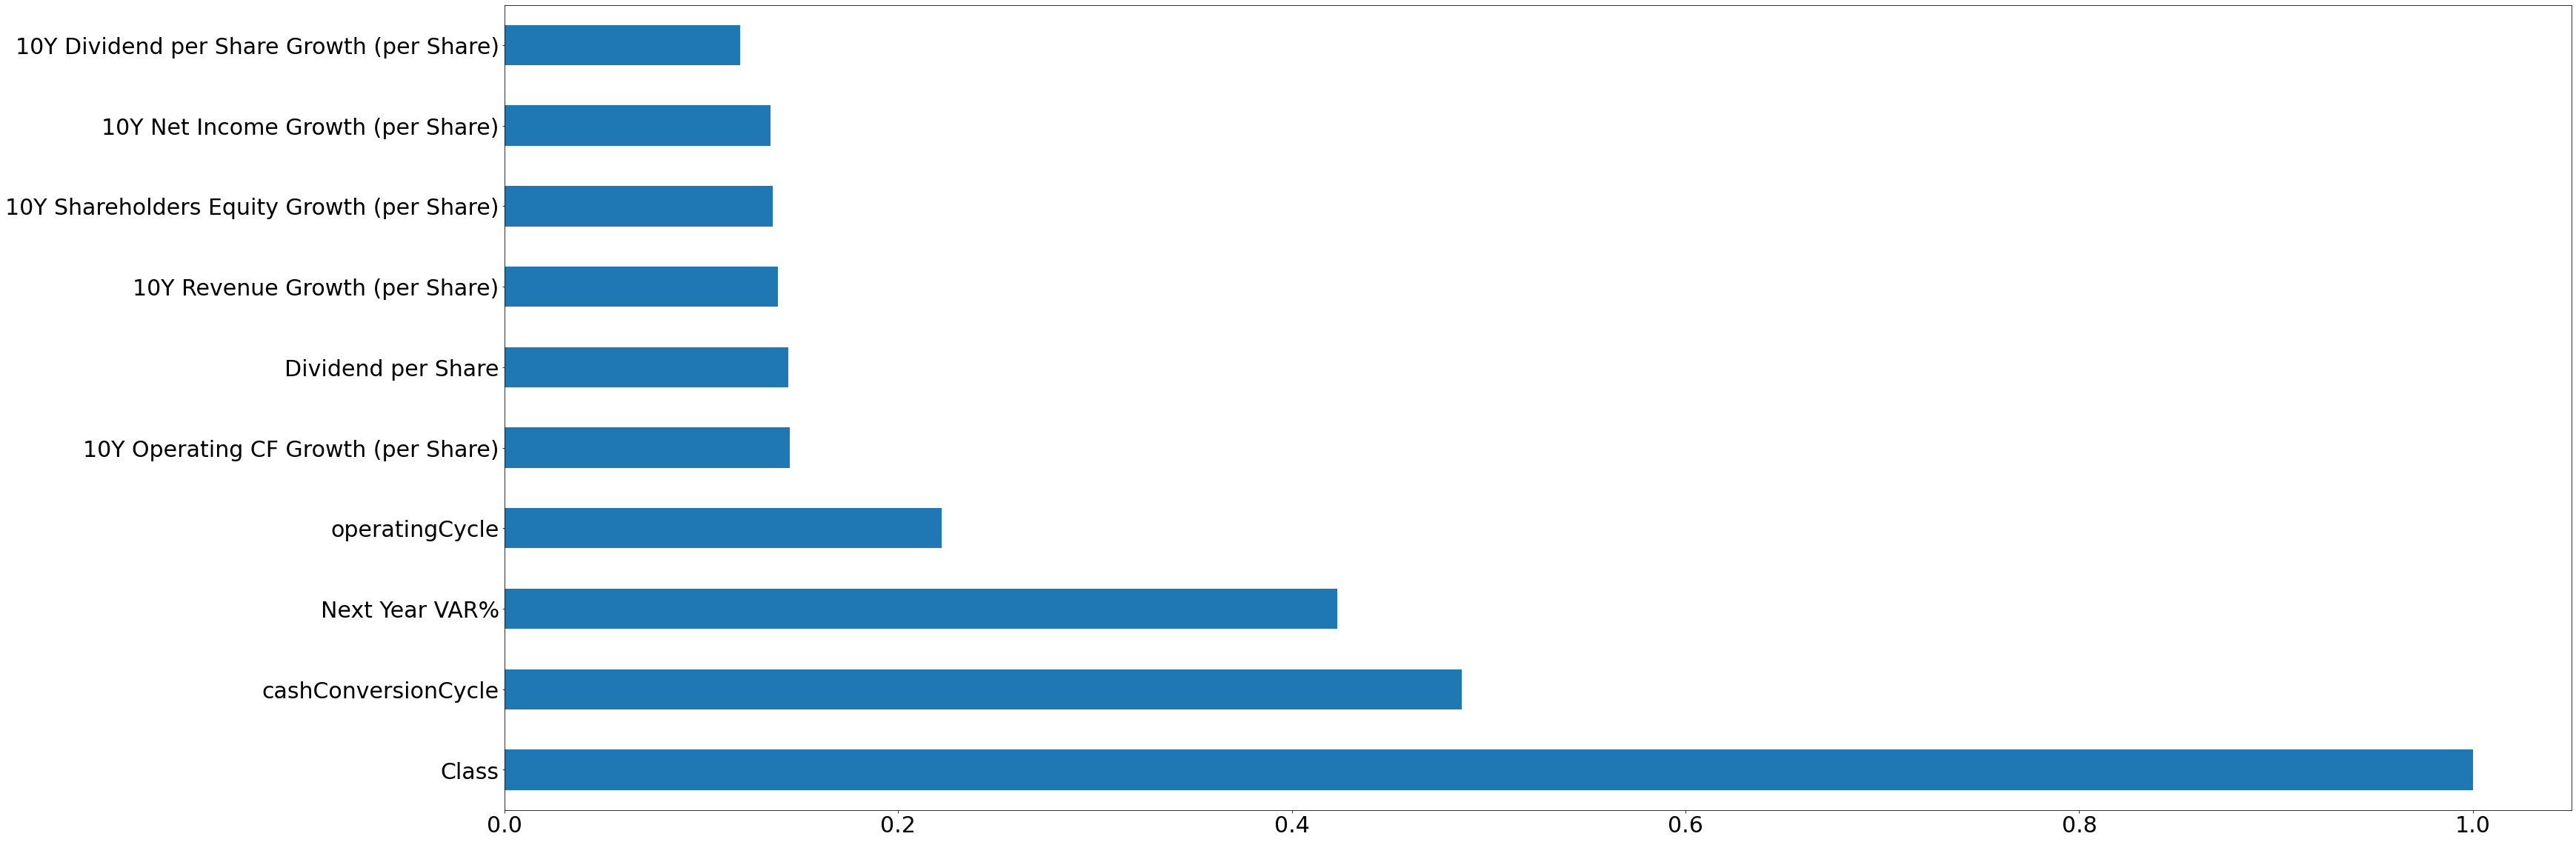

In [826]:
corr_df = stock_data.corr()
c = corr_df['Class'].sort_values(ascending=False).head(10)
# .head(20).index.values
c.plot(kind='barh', figsize=(50,20), fontsize=30)

### Analyze and extract financial indicator
From here we need to extract the most representative financial indicators as the independent variables.
The nominated indicators are:
  1. Profit Margin
  2. Net Profit Margin
  3. Operating Profit Margin
  4. EPS
  5. Return on Assets (ROA)
  6. Return on Equity (ROE)
  7. Price to Free Cash Flows Ratio
  8. Price Earnings Ratio
  9. Price Earnings to Growth Ratio
  10. Asset Turnover
  11. Current Ratio
  12. Quick Ratio
  13. Debt Equity Ratio
  14. Interest Coverage
  15. Receivables Turnover
  16. Invertory Turnover
  17. Working Capital

In [827]:
# Extract the key financial indicators from the dataset.
# The Operating Profit Margin column value is always 1, which seems incorrect.
# Therefore for this indicator using Operating Income divided by Revenue.

indicator_list = ['Data Year', 'Stock', 'Class', 'Next Year VAR%', 
                  'Profit Margin', 
                  'Net Profit Margin', 'EPS Diluted',
                 'returnOnAssets', 'returnOnEquity', 'priceToFreeCashFlowsRatio', 'priceEarningsRatio',
                 'priceEarningsToGrowthRatio', 'assetTurnover', 'currentRatio',
                 'quickRatio', 'debtEquityRatio', 'Interest Coverage', 'Receivables Turnover',
                 'Inventory Turnover', 'Working Capital']
# Assign to new dataset
indicator_data = stock_data[indicator_list]
indicator_data.head(20)

,Data Year,Stock,Class,Next Year VAR%,Profit Margin,Net Profit Margin,EPS Diluted,returnOnAssets,returnOnEquity,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,assetTurnover,currentRatio,quickRatio,debtEquityRatio,Interest Coverage,Receivables Turnover,Inventory Turnover,Working Capital
0,2018,CMCSA,1,32.794573,0.1240,0.1241,2.5300,0.3033,0.1638,12.9254,13.3008,13.136438,0.375499,0.792000,0.540449,1.5604,5.2662,9.4801,0.0000,-5.755000e+09
1,2018,KMI,1,40.588068,0.1050,0.1138,0.6600,0.0446,0.0478,16.0840,23.3030,20.688543,0.179342,0.757000,0.632261,1.1083,2.1455,9.6022,34.9666,-1.835000e+09
2,2018,INTC,1,30.295514,0.2970,0.2972,4.4800,0.3444,0.2824,15.1845,10.2691,10.151625,0.553660,1.731000,1.105016,0.3535,-184.0556,11.4929,9.9534,1.216100e+10
3,2018,MU,1,64.213737,0.4650,0.4651,11.5100,0.4163,0.4377,7.1329,4.2999,4.299931,0.700641,2.787000,2.134168,0.1436,42.8216,6.5803,9.0476,1.028500e+10
4,2018,GE,1,44.757840,-0.1870,-0.1838,-2.6200,NaN,-0.7216,89.2974,0.0000,NaN,0.390955,1.718208,1.402587,3.3440,-3.3036,3.4583,7.3214,NaN
5,2018,BAC,1,44.315988,0.2930,0.3085,2.6100,NaN,0.1061,6.2950,9.3333,8.746366,0.038754,0.411740,0.410799,1.6454,0.0000,1.4320,0.0000,NaN
6,2018,AAPL,1,88.742465,0.2240,0.2241,11.9100,1.0497,0.5556,17.5630,18.9226,18.698888,0.726215,1.133000,0.994540,1.0685,0.0000,6.2738,60.2871,1.541000e+10
7,2018,MSFT,1,58.259263,0.1500,0.1502,2.1300,0.1125,0.2003,23.8769,46.5163,45.728781,0.426351,2.901000,2.739861,0.9890,0.0000,4.5126,45.5751,1.111740e+11
8,2018,SIRI,1,22.161943,0.2040,0.2038,0.2600,-1.4481,-0.6472,16.7094,21.9615,21.576187,0.706068,0.171000,0.102390,-3.7909,5.0579,24.3116,273.4990,-2.325000e+09
9,2018,HPQ,1,3.016789,0.0910,0.0911,3.2600,-3.4457,-8.3365,9.3852,7.3152,7.147383,1.688868,0.851000,0.409017,-9.3693,3.8668,12.2750,9.8704,-3.744000e+09


In [828]:
indicator_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Data Year                   4392 non-null   int64  
 1   Stock                       4392 non-null   object 
 2   Class                       4392 non-null   int64  
 3   Next Year VAR%              4392 non-null   float64
 4   Profit Margin               4086 non-null   float64
 5   Net Profit Margin           4216 non-null   float64
 6   EPS Diluted                 4329 non-null   float64
 7   returnOnAssets              3286 non-null   float64
 8   returnOnEquity              4136 non-null   float64
 9   priceToFreeCashFlowsRatio   4139 non-null   float64
 10  priceEarningsRatio          4140 non-null   float64
 11  priceEarningsToGrowthRatio  2734 non-null   float64
 12  assetTurnover               4162 non-null   float64
 13  currentRatio                4141 

In [829]:
feature_column = indicator_data.columns.values.tolist()[3:]

<AxesSubplot:>

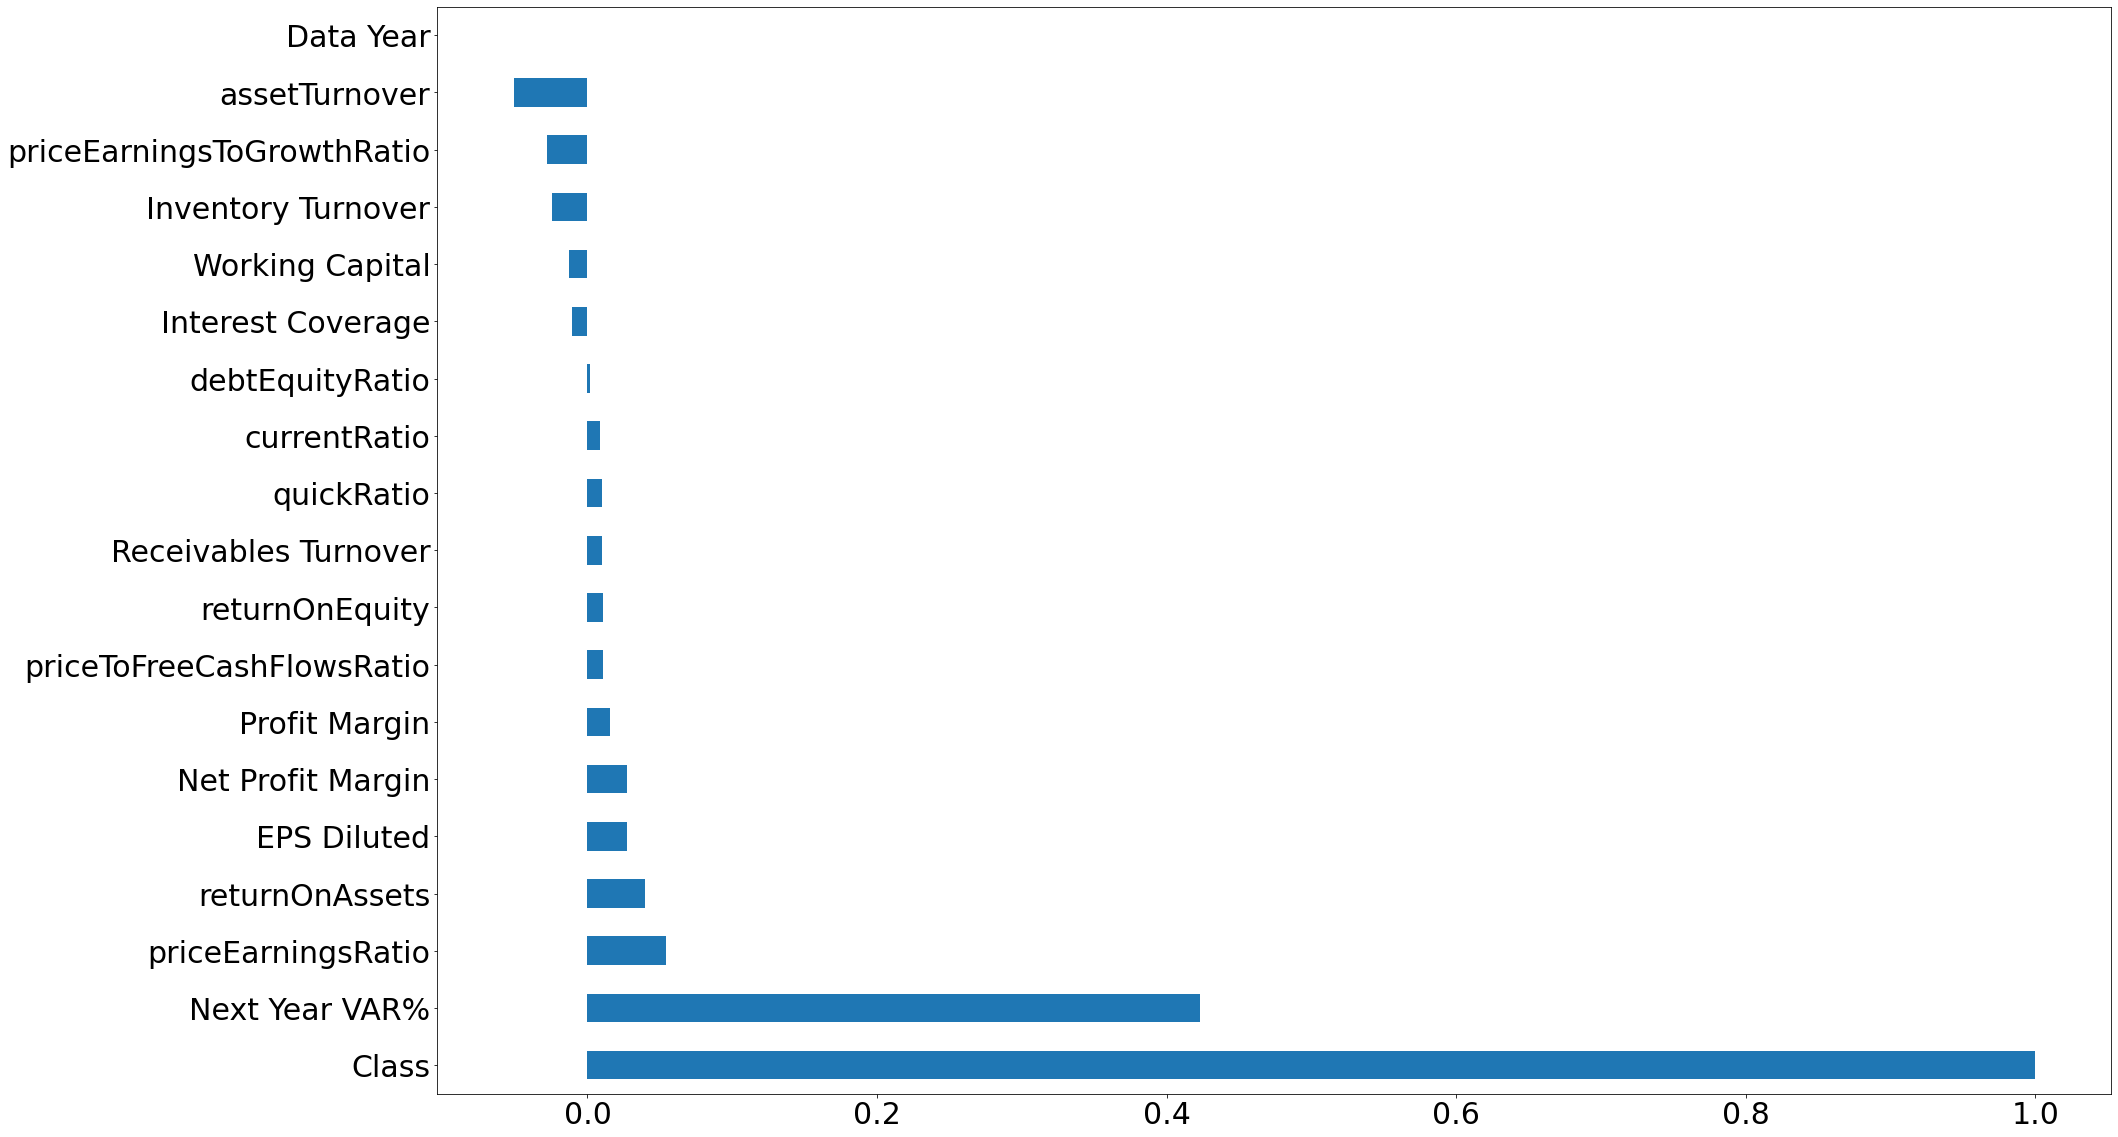

In [830]:
corr_df = indicator_data.corr()
corr_df
c = corr_df['Class'].sort_values(ascending=False)
c.plot(kind='barh', figsize=(30,20), fontsize=30)

### Clean NA values
Here the na values are dropped, instead of filled with zero or make-up figure to maintain feature quality.

In [769]:
def get_na_columns(df):
    columns = df.columns
    columns_has_na = []
    for column in columns:
        has_na = df[column].isna().any().sum()
        if(has_na>0):
            columns_has_na.append(column)
    return columns_has_na

In [770]:
# Deal with NA data
# Focus on financial indicator dataset.
# To maintain model quality, I drop the records with NA values instead of filling 0.
indicator_data = indicator_data.dropna()
indicator_data.shape

(1955, 20)

In [771]:
# Verify if there is any na exists.
s = get_na_columns(indicator_data)
len(s)

0

In [772]:
indicator_data.reset_index(drop=True, inplace=True)
indicator_data.head(20)

,Data Year,Stock,Class,Next Year VAR%,Profit Margin,Net Profit Margin,EPS Diluted,returnOnAssets,returnOnEquity,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,assetTurnover,currentRatio,quickRatio,debtEquityRatio,Interest Coverage,Receivables Turnover,Inventory Turnover,Working Capital
0,2018,CMCSA,1,32.794573,0.1240,0.1241,2.5300,0.3033,0.1638,12.9254,13.3008,13.136438,0.375499,0.7920,0.540449,1.5604,5.2662,9.4801,0.0000,-5.755000e+09
1,2018,KMI,1,40.588068,0.1050,0.1138,0.6600,0.0446,0.0478,16.0840,23.3030,20.688543,0.179342,0.7570,0.632261,1.1083,2.1455,9.6022,34.9666,-1.835000e+09
2,2018,INTC,1,30.295514,0.2970,0.2972,4.4800,0.3444,0.2824,15.1845,10.2691,10.151625,0.553660,1.7310,1.105016,0.3535,-184.0556,11.4929,9.9534,1.216100e+10
3,2018,MU,1,64.213737,0.4650,0.4651,11.5100,0.4163,0.4377,7.1329,4.2999,4.299931,0.700641,2.7870,2.134168,0.1436,42.8216,6.5803,9.0476,1.028500e+10
4,2018,AAPL,1,88.742465,0.2240,0.2241,11.9100,1.0497,0.5556,17.5630,18.9226,18.698888,0.726215,1.1330,0.994540,1.0685,0.0000,6.2738,60.2871,1.541000e+10
5,2018,MSFT,1,58.259263,0.1500,0.1502,2.1300,0.1125,0.2003,23.8769,46.5163,45.728781,0.426351,2.9010,2.739861,0.9890,0.0000,4.5126,45.5751,1.111740e+11
6,2018,SIRI,1,22.161943,0.2040,0.2038,0.2600,-1.4481,-0.6472,16.7094,21.9615,21.576187,0.706068,0.1710,0.102390,-3.7909,5.0579,24.3116,273.4990,-2.325000e+09
7,2018,HPQ,1,3.016789,0.0910,0.0911,3.2600,-3.4457,-8.3365,9.3852,7.3152,7.147383,1.688868,0.8510,0.409017,-9.3693,3.8668,12.2750,9.8704,-3.744000e+09
8,2018,CX,0,-21.971692,0.0019,0.0378,0.1122,-0.0467,0.0555,14.6474,42.9590,20.870413,0.500979,0.0381,0.459951,1.1011,2.1855,7.8176,13.8314,-2.289100e+10
9,2018,CZR,1,96.531795,0.0360,0.0361,0.4100,0.0186,0.0932,21.0767,15.4318,15.372739,0.325548,1.1330,1.060000,5.8591,1.1352,17.3368,209.7750,2.650000e+08


### Check the skew and normalize the data

In [773]:
# Check skew
indicator_data.skew()

Data Year                      0.000000
Class                         -1.010378
Next Year VAR%                 0.473871
Profit Margin                 24.852242
Net Profit Margin             40.057755
EPS Diluted                   44.215133
returnOnAssets                13.883660
returnOnEquity                 3.714219
priceToFreeCashFlowsRatio     26.207001
priceEarningsRatio            16.430980
priceEarningsToGrowthRatio    21.740647
assetTurnover                  3.352897
currentRatio                   9.505593
quickRatio                    10.078875
debtEquityRatio               26.818857
Interest Coverage             43.961027
Receivables Turnover          21.869920
Inventory Turnover            43.805785
Working Capital               29.608817
dtype: float64

array([[<AxesSubplot:title={'center':'Next Year VAR%'}>,
        <AxesSubplot:title={'center':'Profit Margin'}>,
        <AxesSubplot:title={'center':'Net Profit Margin'}>,
        <AxesSubplot:title={'center':'EPS Diluted'}>],
       [<AxesSubplot:title={'center':'returnOnAssets'}>,
        <AxesSubplot:title={'center':'returnOnEquity'}>,
        <AxesSubplot:title={'center':'priceToFreeCashFlowsRatio'}>,
        <AxesSubplot:title={'center':'priceEarningsRatio'}>],
       [<AxesSubplot:title={'center':'priceEarningsToGrowthRatio'}>,
        <AxesSubplot:title={'center':'assetTurnover'}>,
        <AxesSubplot:title={'center':'currentRatio'}>,
        <AxesSubplot:title={'center':'quickRatio'}>],
       [<AxesSubplot:title={'center':'debtEquityRatio'}>,
        <AxesSubplot:title={'center':'Interest Coverage'}>,
        <AxesSubplot:title={'center':'Receivables Turnover'}>,
        <AxesSubplot:title={'center':'Inventory Turnover'}>],
       [<AxesSubplot:title={'center':'Working Capit

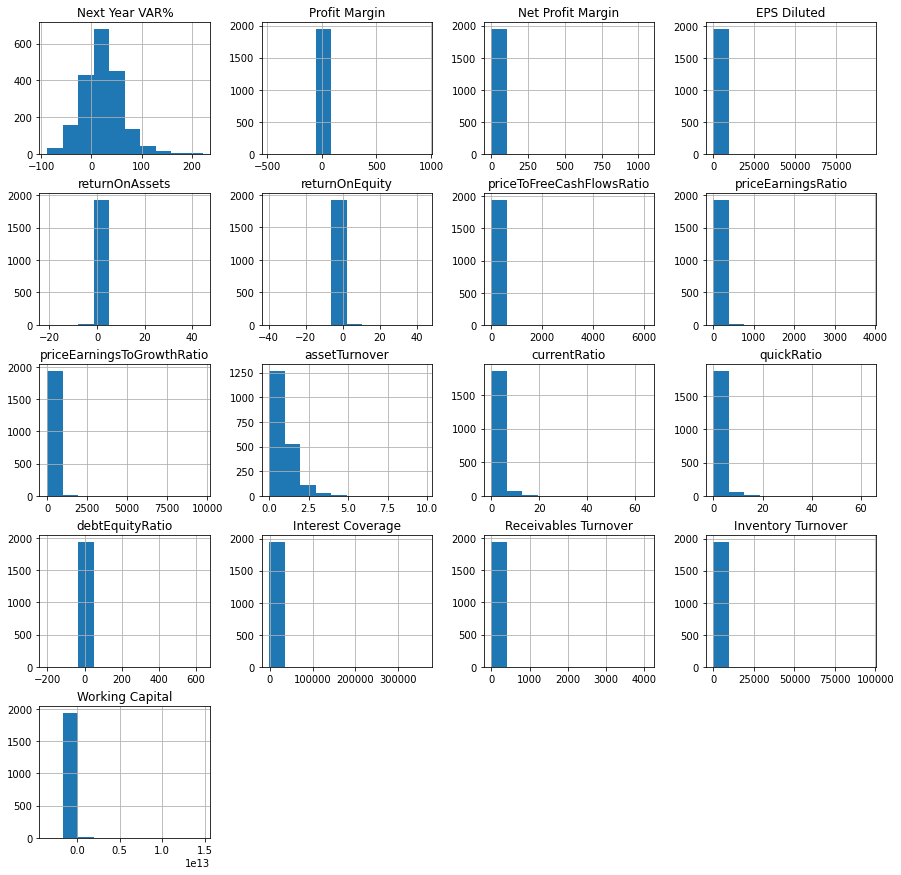

In [774]:
indicator_data[feature_column].hist(figsize=(15,15))

In [775]:
# Fix the skew and normalize the data with log
for c in indicator_list[3:]:
    arr_values = indicator_data[c].values
    logarr = []
#     print(arr_values)
    for value in arr_values:
        if (value < 0):
            value = np.log1p(np.abs(value))*-1
        else:
            value = np.log1p(value)
        logarr.append(value)    
    indicator_data[c] = logarr

indicator_data.skew()

Data Year                      0.000000
Class                         -1.010378
Next Year VAR%                -0.887898
Profit Margin                  6.840723
Net Profit Margin             16.189745
EPS Diluted                    1.867669
returnOnAssets                -0.312514
returnOnEquity                -0.423811
priceToFreeCashFlowsRatio     -0.281104
priceEarningsRatio             0.513274
priceEarningsToGrowthRatio     0.721049
assetTurnover                  0.923419
currentRatio                   1.054312
quickRatio                     1.647107
debtEquityRatio               -1.018057
Interest Coverage             -0.189418
Receivables Turnover           1.389525
Inventory Turnover             0.517996
Working Capital               -1.644021
dtype: float64

array([[<AxesSubplot:title={'center':'Next Year VAR%'}>,
        <AxesSubplot:title={'center':'Profit Margin'}>,
        <AxesSubplot:title={'center':'Net Profit Margin'}>,
        <AxesSubplot:title={'center':'EPS Diluted'}>],
       [<AxesSubplot:title={'center':'returnOnAssets'}>,
        <AxesSubplot:title={'center':'returnOnEquity'}>,
        <AxesSubplot:title={'center':'priceToFreeCashFlowsRatio'}>,
        <AxesSubplot:title={'center':'priceEarningsRatio'}>],
       [<AxesSubplot:title={'center':'priceEarningsToGrowthRatio'}>,
        <AxesSubplot:title={'center':'assetTurnover'}>,
        <AxesSubplot:title={'center':'currentRatio'}>,
        <AxesSubplot:title={'center':'quickRatio'}>],
       [<AxesSubplot:title={'center':'debtEquityRatio'}>,
        <AxesSubplot:title={'center':'Interest Coverage'}>,
        <AxesSubplot:title={'center':'Receivables Turnover'}>,
        <AxesSubplot:title={'center':'Inventory Turnover'}>],
       [<AxesSubplot:title={'center':'Working Capit

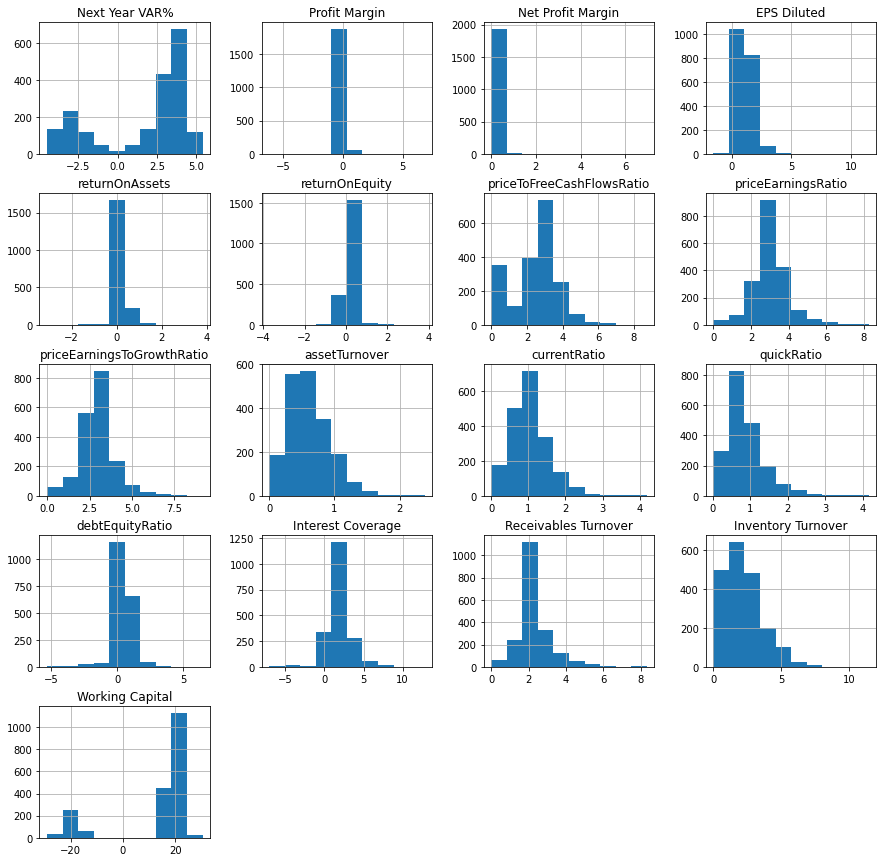

In [776]:
indicator_data[feature_column].hist(figsize=(15,15))

### Scale the data to improve the outliers
Here we scale the features to decrease the effects of outliers and try to get better normalized data.

In [777]:
def get_box(df, columns):
    j=0
    d=0
    while (j<=4):
        figure, axs = plt.subplots(1, 4)
        figure.set_figheight(10)
        figure.set_figwidth(18)
    
        for i, column in enumerate(columns[d:d+4]):
            axs[i].boxplot(df[column], 0, 'gD', showmeans=True, 
                           widths=0.5)
            axs[i].set_title(column)
        
        j+=1
        d+=4   

In [778]:
def check_IQR(df, column):
    scale = 1.5
    describe_df = df[column].describe()
    Q1 = describe_df['25%']
    Q3 = describe_df['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - scale*IQR
    upper_bound = Q3 + scale*IQR
    return df[column].loc[(df[column]<lower_bound)|(df[column]>upper_bound)]

In [779]:
# Use 1.5 IQR to isolate and drop outliers
tmp_index_list=[]
for check_column in feature_column:
    column_outlier_df = check_IQR(indicator_data, check_column)
    print('Column {} has {} outlier data'.format(check_column, column_outlier_df.shape[0]))
#     add index to temp list
    tmp_index_list.extend(column_outlier_df.index.values.tolist())

outlier_index = set(tmp_index_list)
# Try to drop the outliers
indicator_data.drop(index=outlier_index, inplace=True)
indicator_data.shape
indicator_data['Data Year'].value_counts()

Column Next Year VAR% has 0 outlier data
Column Profit Margin has 118 outlier data
Column Net Profit Margin has 120 outlier data
Column EPS Diluted has 19 outlier data
Column returnOnAssets has 164 outlier data
Column returnOnEquity has 186 outlier data
Column priceToFreeCashFlowsRatio has 28 outlier data
Column priceEarningsRatio has 143 outlier data
Column priceEarningsToGrowthRatio has 158 outlier data
Column assetTurnover has 29 outlier data
Column currentRatio has 64 outlier data
Column quickRatio has 84 outlier data
Column debtEquityRatio has 129 outlier data
Column Interest Coverage has 129 outlier data
Column Receivables Turnover has 207 outlier data
Column Inventory Turnover has 42 outlier data
Column Working Capital has 360 outlier data


2018    930
Name: Data Year, dtype: int64

In [780]:
# indicator_data = indicator_data.dropna()
# indicator_data.shape
indicator_data

,Data Year,Stock,Class,Next Year VAR%,Profit Margin,Net Profit Margin,EPS Diluted,returnOnAssets,returnOnEquity,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,assetTurnover,currentRatio,quickRatio,debtEquityRatio,Interest Coverage,Receivables Turnover,Inventory Turnover,Working Capital
5,2018,MSFT,1,4.081922,0.139762,0.139936,1.141033,0.106610,0.182572,3.213940,3.861073,3.844360,0.355119,1.361233,1.319048,0.687632,0.000000,1.707036,3.841066,25.434362
10,2018,F,1,3.278548,0.022739,0.022642,0.652325,0.064382,0.097399,1.649600,2.222004,2.197879,0.485509,0.788457,0.964057,1.666158,1.709030,0.848312,2.729055,23.671907
11,2018,AMD,1,4.973608,0.050693,0.050693,0.277632,0.162969,0.236020,0.000000,4.012666,4.003534,0.884264,1.023889,0.790792,0.686827,1.549837,2.159557,2.242262,21.165384
14,2018,VALE,1,0.459199,0.172271,0.171934,0.841567,0.118405,0.144966,2.142346,2.397204,2.397287,0.346938,0.985070,0.679666,0.371357,1.579391,2.703948,2.276303,22.544746
16,2018,ORCL,1,3.003629,0.087095,0.087186,0.615186,0.055435,0.074551,2.715026,4.001884,3.985360,0.251298,1.605831,1.565624,0.836035,2.096213,2.145639,0.000000,24.766931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944,2018,USDP,1,2.160002,0.162969,0.163139,0.570980,0.128041,0.265590,2.140066,2.679061,2.570396,0.347126,1.036027,0.944938,1.376118,1.288020,3.180875,0.000000,16.059725
1947,2018,WHLM,0,-3.400797,0.010940,0.010940,0.148420,0.116805,0.032274,2.339486,3.622673,3.618663,1.029791,0.832474,0.826748,0.095765,2.622659,1.959996,0.000000,15.284076
1952,2018,WVVI,0,-1.405343,0.076961,0.116805,0.314811,0.049742,0.058363,0.000000,2.976631,2.562326,0.318735,1.841660,1.175858,0.161779,2.361571,2.503319,0.911117,16.961345
1953,2018,XELB,1,3.336433,0.030529,0.030238,0.058269,0.094674,0.010841,1.616811,2.987362,2.995056,0.228641,0.908662,0.802678,0.178983,1.586620,1.532665,3.602234,15.864364


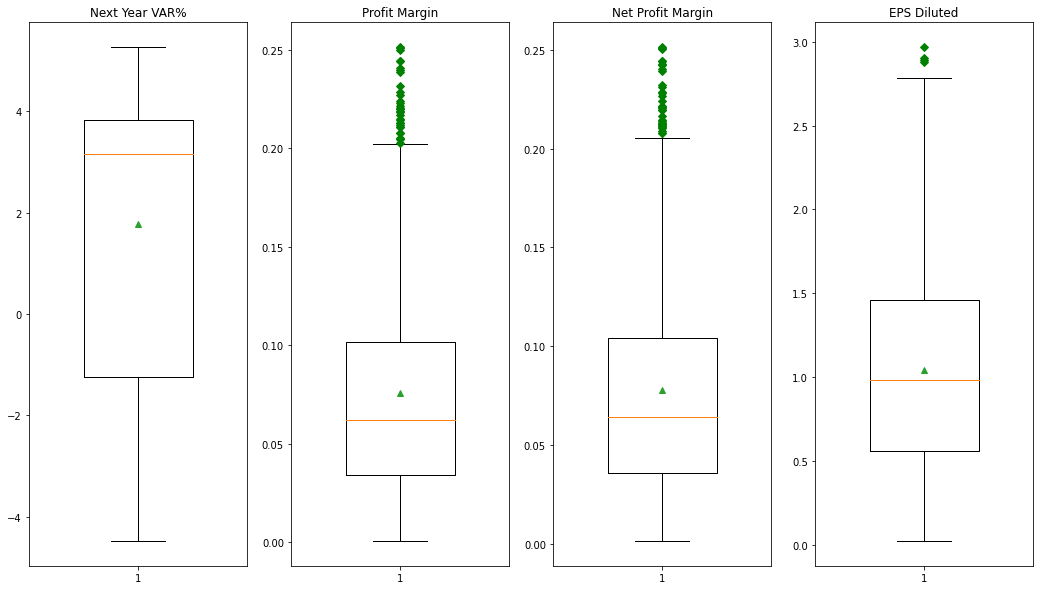

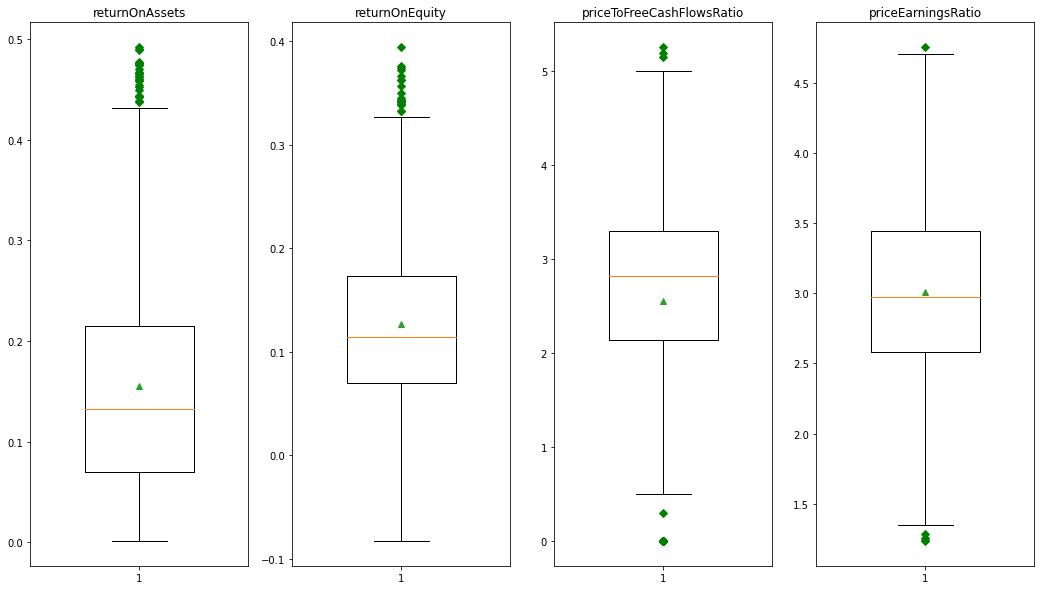

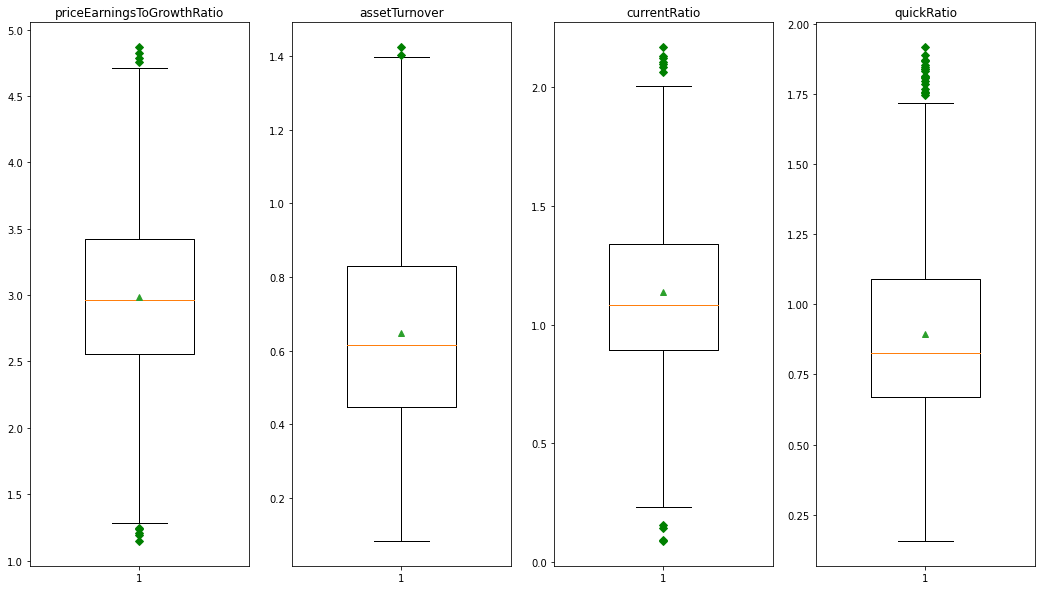

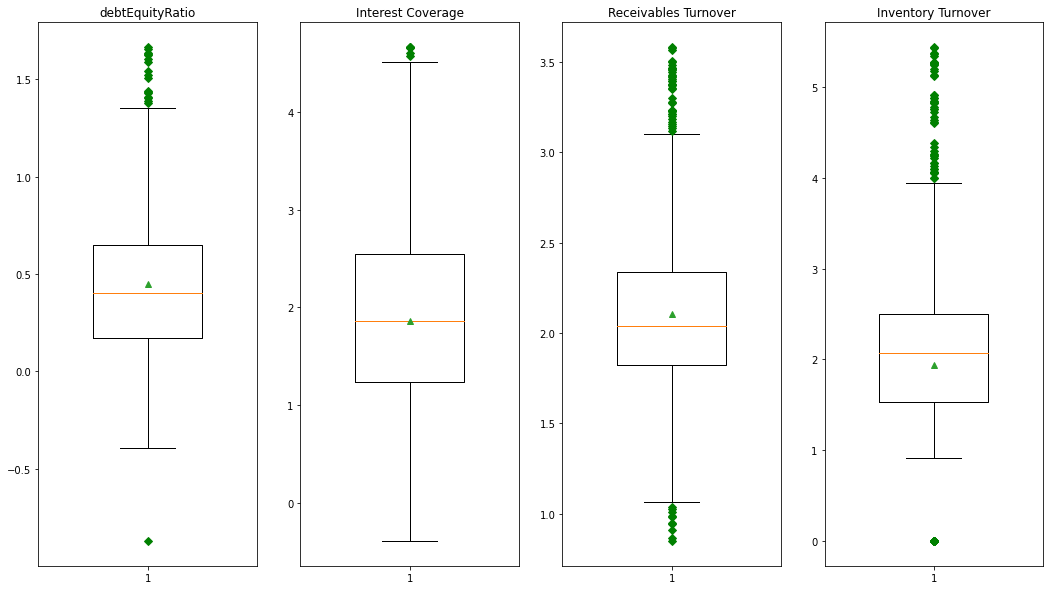

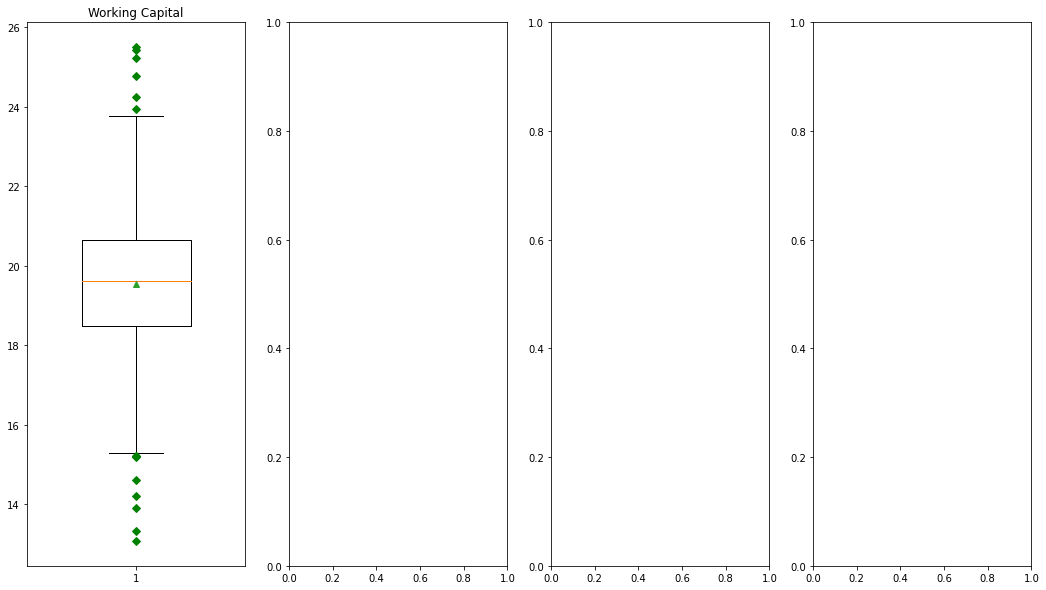

In [781]:
get_box(indicator_data, feature_column)

In [782]:
# Before scaling
# example[columns].describe().T
indicator_data[feature_column].describe().T

,count,mean,std,min,25%,50%,75%,max
Next Year VAR%,930.0,1.766375,2.859984,-4.482131,-1.252658,3.147481,3.834491,5.267894
Profit Margin,930.0,0.075645,0.054102,0.000700,0.034401,0.062035,0.101654,0.251537
Net Profit Margin,930.0,0.077757,0.054670,0.001499,0.035970,0.064288,0.104225,0.251459
EPS Diluted,930.0,1.045425,0.616880,0.021957,0.559616,0.980390,1.462676,2.969902
returnOnAssets,930.0,0.155120,0.110548,0.001099,0.069316,0.131905,0.215152,0.492071
returnOnEquity,930.0,0.126967,0.076821,-0.082962,0.069643,0.114310,0.173113,0.394741
priceToFreeCashFlowsRatio,930.0,2.549041,1.205128,0.000000,2.142601,2.824036,3.298640,5.257439
priceEarningsRatio,930.0,3.008711,0.653939,1.234483,2.582534,2.971376,3.445070,4.755887
priceEarningsToGrowthRatio,930.0,2.987494,0.673801,1.147065,2.553320,2.964866,3.422787,4.868957
assetTurnover,930.0,0.647448,0.264649,0.082315,0.446351,0.615771,0.828903,1.425294


In [783]:
# Scale the rest features
scaler = MinMaxScaler()
# scaler = RobustScaler()
example_standardized = scaler.fit_transform(indicator_data[feature_column])
# example_standardized.shape
example_standardized_df = pd.DataFrame(data=example_standardized, columns=feature_column)

In [784]:
example_standardized_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Next Year VAR%,930.0,0.640871,0.293331,0.0,0.331227,0.782522,0.852985,1.0
Profit Margin,930.0,0.298781,0.215685,0.0,0.134357,0.244524,0.402468,1.0
Net Profit Margin,930.0,0.305080,0.218714,0.0,0.137908,0.251199,0.410970,1.0
EPS Diluted,930.0,0.347180,0.209258,0.0,0.182384,0.325119,0.488720,1.0
returnOnAssets,930.0,0.313706,0.225161,0.0,0.138942,0.266422,0.435977,1.0
returnOnEquity,930.0,0.439454,0.160812,0.0,0.319454,0.412960,0.536053,1.0
priceToFreeCashFlowsRatio,930.0,0.484845,0.229223,0.0,0.407537,0.537151,0.627423,1.0
priceEarningsRatio,930.0,0.503841,0.185704,0.0,0.382817,0.493239,0.627757,1.0
priceEarningsToGrowthRatio,930.0,0.494487,0.181037,0.0,0.377833,0.488408,0.611442,1.0
assetTurnover,930.0,0.420806,0.197061,0.0,0.271066,0.397218,0.555919,1.0


In [785]:
indicator_data.shape
a = indicator_data[['Data Year', 'Stock', 'Class']]
# a.dropna(inplace=True)
a.reset_index(inplace=True, drop=True)
a
example_standardized_df
indicator_data = pd.concat([a, example_standardized_df], axis=1)
indicator_data

,Data Year,Stock,Class,Next Year VAR%,Profit Margin,Net Profit Margin,EPS Diluted,returnOnAssets,returnOnEquity,priceToFreeCashFlowsRatio,priceEarningsRatio,priceEarningsToGrowthRatio,assetTurnover,currentRatio,quickRatio,debtEquityRatio,Interest Coverage,Receivables Turnover,Inventory Turnover,Working Capital
0,2018,MSFT,1,0.878362,0.554393,0.553837,0.379612,0.214901,0.555854,0.611313,0.745893,0.724711,0.203134,0.611600,0.660070,0.614411,0.077178,0.314095,0.706135,0.993968
1,2018,F,1,0.795965,0.087865,0.084585,0.213833,0.128893,0.377558,0.313765,0.280434,0.282333,0.300224,0.336404,0.458631,1.000000,0.415368,0.000000,0.501705,0.852345
2,2018,AMD,1,0.969817,0.199306,0.196808,0.086730,0.329692,0.667741,0.000000,0.788942,0.767478,0.597142,0.449520,0.360311,0.614094,0.383866,0.479613,0.412214,0.650932
3,2018,VALE,1,0.506802,0.683996,0.681851,0.278028,0.238926,0.477132,0.407489,0.330187,0.335910,0.197042,0.430869,0.297253,0.489782,0.389715,0.678734,0.418472,0.761772
4,2018,ORCL,1,0.767768,0.344427,0.342805,0.201235,0.110669,0.329729,0.516416,0.785880,0.762595,0.125827,0.729120,0.799989,0.672889,0.491986,0.474522,0.000000,0.940337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,2018,USDP,1,0.681243,0.646911,0.646663,0.186239,0.258553,0.729641,0.407055,0.410228,0.382421,0.197182,0.455352,0.447782,0.885709,0.332057,0.853179,0.000000,0.240664
926,2018,WHLM,0,0.110906,0.040824,0.037770,0.042899,0.235666,0.241228,0.444986,0.678193,0.664070,0.705503,0.357553,0.380714,0.381185,0.596161,0.406619,0.000000,0.178336
927,2018,WVVI,0,0.315567,0.304027,0.461297,0.099342,0.099074,0.295843,0.000000,0.494731,0.380253,0.176042,0.842426,0.578816,0.407198,0.544496,0.605350,0.167498,0.313114
928,2018,XELB,1,0.801902,0.118920,0.114976,0.012318,0.190590,0.196362,0.307528,0.497779,0.496519,0.108956,0.394158,0.367056,0.413977,0.391145,0.250315,0.662229,0.224966


array([[<AxesSubplot:title={'center':'Next Year VAR%'}>,
        <AxesSubplot:title={'center':'Profit Margin'}>,
        <AxesSubplot:title={'center':'Net Profit Margin'}>,
        <AxesSubplot:title={'center':'EPS Diluted'}>],
       [<AxesSubplot:title={'center':'returnOnAssets'}>,
        <AxesSubplot:title={'center':'returnOnEquity'}>,
        <AxesSubplot:title={'center':'priceToFreeCashFlowsRatio'}>,
        <AxesSubplot:title={'center':'priceEarningsRatio'}>],
       [<AxesSubplot:title={'center':'priceEarningsToGrowthRatio'}>,
        <AxesSubplot:title={'center':'assetTurnover'}>,
        <AxesSubplot:title={'center':'currentRatio'}>,
        <AxesSubplot:title={'center':'quickRatio'}>],
       [<AxesSubplot:title={'center':'debtEquityRatio'}>,
        <AxesSubplot:title={'center':'Interest Coverage'}>,
        <AxesSubplot:title={'center':'Receivables Turnover'}>,
        <AxesSubplot:title={'center':'Inventory Turnover'}>],
       [<AxesSubplot:title={'center':'Working Capit

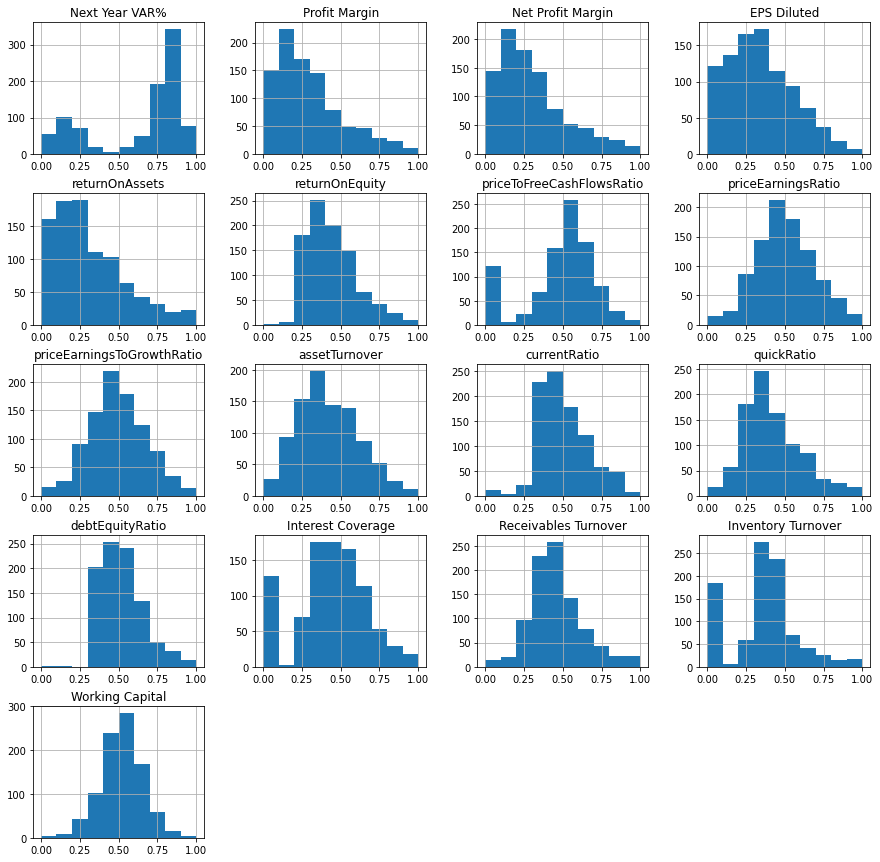

In [786]:
indicator_data[feature_column].hist(figsize=(15,15))

In [787]:
s = indicator_data.corr()['Class'].sort_values(ascending=False)
s.describe()
# s.plot(kind='barh', figsize=(50,20), fontsize=30)

count    18.000000
mean      0.177194
std       0.305092
min      -0.074068
25%       0.025484
50%       0.081404
75%       0.171490
max       1.000000
Name: Class, dtype: float64

In [788]:
indicator_data['Class'].value_counts()

1    683
0    247
Name: Class, dtype: int64

## Modeling
Here we start to create and evaluate various unsupervised models.

In [789]:
X = indicator_data[feature_column].values
X.shape

(930, 17)

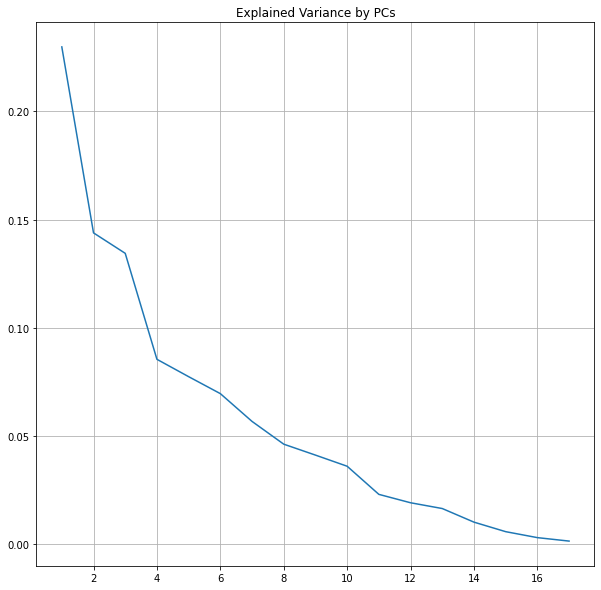

In [790]:
# Using Principle Components to define scale down the variables
# Determine the number of PC
PCA_test = PCA(n_components=len(feature_column))
PCA_test.fit(X)
plt.figure(figsize=(10,10))
plt.grid()
plt.title('Explained Variance by PCs')
plt.plot(range(1,len(feature_column)+1), PCA_test.explained_variance_ratio_)

In [791]:
# Create 2 principle components to interpret the data
PCA_model = PCA(n_components=2)
PCA_model.fit(X)
print(PCA_model.explained_variance_)
print(PCA_model.explained_variance_ratio_)
# print('The PCA score = {}'.format(ss.shape))
PCA_X = PCA_model.fit_transform(X)
PCA_X.shape

[0.1570505  0.09832789]
[0.22975552 0.14384784]


(930, 2)

In [792]:
df_t = pd.DataFrame(PCA_X)
df_t[0].dtypes
# df_t['0']
# df_t.plot(kind='scatter', x=df_t[0], y=df_t[1])

dtype('float64')

### Kmeans clustering

C:\Users\mikee\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  f"KMeans is known to have a memory leak on Windows "


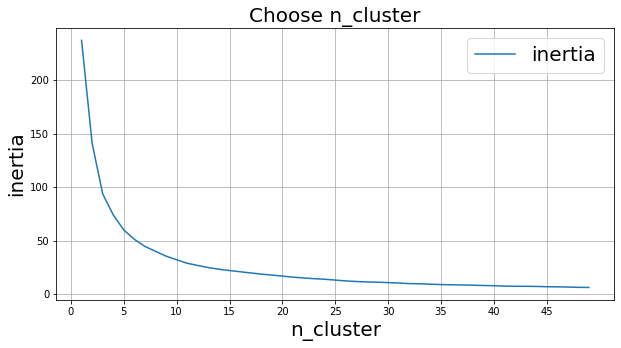

In [793]:
# Here we start with Kmeans to cluster the stock data
n_clusters = range(1,50)
k_df = pd.DataFrame()
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=0).fit(PCA_X)
    inertia = kmeans.inertia_
    s = pd.Series({'n_cluster':n,
                  'inertia': inertia})
    k_df = k_df.append(s, ignore_index=True)
ax = k_df.plot(kind='line', x='n_cluster', y='inertia', figsize=(10,5), grid=True)
ax.set_title('Choose n_cluster', fontsize=20)
ax.set_xlabel('n_cluster', fontsize=20)
ax.set_ylabel('inertia', fontsize=20)
ax.set_xticks(range(0,50,5))
ax.legend(fontsize=20)

In [794]:
def display_cluster(X,km=[],num_clusters=0):
    plt.figure(figsize=(10,10))
    color = 'brgcmyk'
    alpha = 0.8
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
#         for i in range(num_clusters):
        for i in num_clusters:
#             plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[np.abs(i)],alpha = alpha,s=s)
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],alpha = alpha,s=s)
#             plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)
#             plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1], marker = 'x', s = 100)

In [795]:
c_df = pd.DataFrame()

def add_result(model, label):
    s1 = pd.Series({'model': model,
                   'silhouette_score':silhouette_score(PCA_X, label),
                   'calinski_harabasz_score':calinski_harabasz_score(PCA_X, label)})
#     c_df = c_df.append(s1, ignore_index=True)
    return s1

In [796]:
# Get the insight from KMeans clustering
def cluster_report(df, n_cluster=range(0,5), key_column='kmeans cluster'):
    tmp_column = df.columns.to_list()
    tmp_column1 = tmp_column[0:3]
    tmp_column1.append(tmp_column[-1])
    tmp_column1.extend(tmp_column[3:-1])
    df = df[tmp_column1]
    report_df = pd.DataFrame()
    for cluster in n_cluster:
        cluster_df = df.loc[df[key_column]==cluster]
        s = pd.Series({'cluster':cluster,
                  'Next Year VAR%': cluster_df['Next Year VAR%'].mean(),
                  'EPS Diluted': cluster_df['EPS Diluted'].mean(),
                  'Profit Margin': cluster_df['Profit Margin'].mean(),
                  'Net Profit Margin': cluster_df['Net Profit Margin'].mean()
#                       'returnOnAssets': cluster_df['returnOnAssets'].mean(),
#                       'returnOnEquity': cluster_df['returnOnEquity'].mean(),
#                       'priceToFreeCashFlowsRatio': cluster_df['priceToFreeCashFlowsRatio'].mean(),
#                       'priceEarningsRatio': cluster_df['priceEarningsRatio'].mean(),
#                       'priceEarningsToGrowthRatio': cluster_df['priceEarningsToGrowthRatio'].mean(),
#                       'assetTurnover': cluster_df['assetTurnover'].mean(),
#                       'currentRatio': cluster_df['currentRatio'].mean(),
#                       'quickRatio': cluster_df['quickRatio'].mean(),
#                       'debtEquityRatio': cluster_df['debtEquityRatio'].mean(),
#                       'Interest Coverage': cluster_df['Interest Coverage'].mean(),
#                       'Receivables Turnover': cluster_df['Receivables Turnover'].mean(),
#                       'Inventory Turnover': cluster_df['Inventory Turnover'].mean(),
#                       'Working Capital': cluster_df['Working Capital'].mean()
                      })
        report_df = report_df.append(s, ignore_index=True)
#         report_df = report_df.append(cluster_df.mean(), ignore_index=True)
    return report_df

59.96634424572852
Cluster 0 has 258 data points
Cluster 1 has 161 data points
Cluster 2 has 139 data points
Cluster 3 has 138 data points
Cluster 4 has 234 data points


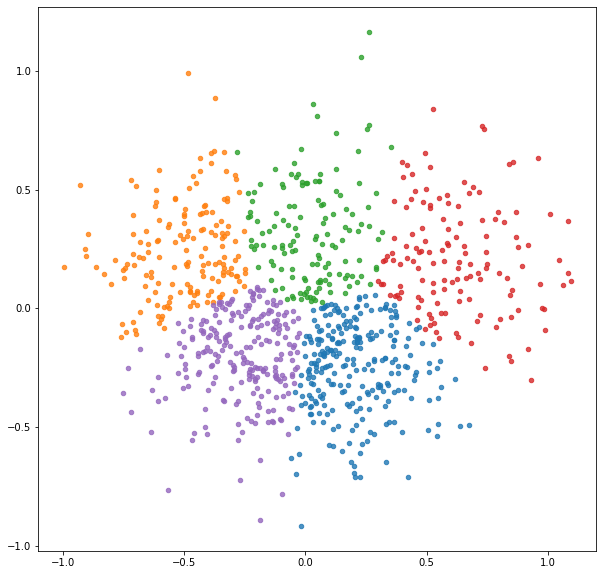

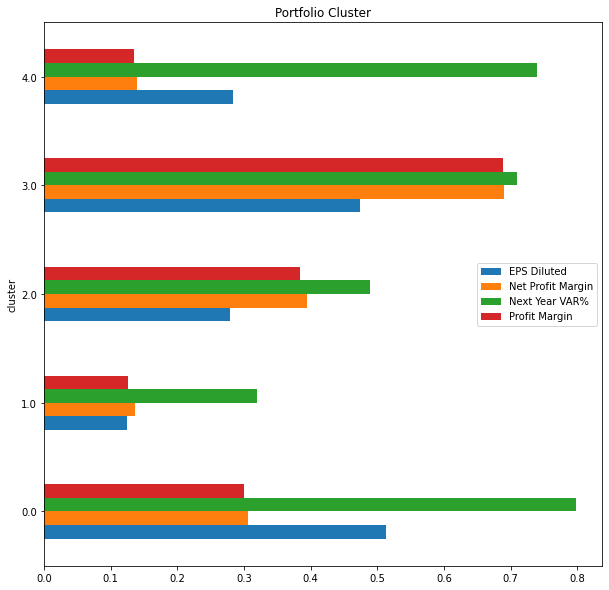

In [797]:
# Set n_cluster = 5 according to elbow method and fit PCA X
kmeans = KMeans(n_clusters=5, random_state=0).fit(PCA_X)
inertia = kmeans.inertia_
print(inertia)
PCA_label_array = kmeans.predict(PCA_X)

for c in set(PCA_label_array):
    print('Cluster {} has {} data points'.format(c, PCA_X[kmeans.labels_ == c].shape[0]))
    
display_cluster(PCA_X, kmeans, num_clusters=set(PCA_label_array))

tmp_df = indicator_data.copy()
# tmp_df['kmeans cluster'] = label_array
tmp_df['kmeans cluster'] = PCA_label_array
report_df = cluster_report(tmp_df)
report_df.set_index('cluster', inplace=True, drop=True)
report_df.plot(kind='barh', figsize=(10,10), title='Portfolio Cluster')
c_df = c_df.append(add_result('KMeans', label_array), ignore_index=True)

422.4948899531964
Cluster 0 has 204 data points
Cluster 1 has 117 data points
Cluster 2 has 261 data points
Cluster 3 has 189 data points
Cluster 4 has 159 data points


<AxesSubplot:title={'center':'Portfolio Cluster'}, ylabel='cluster'>

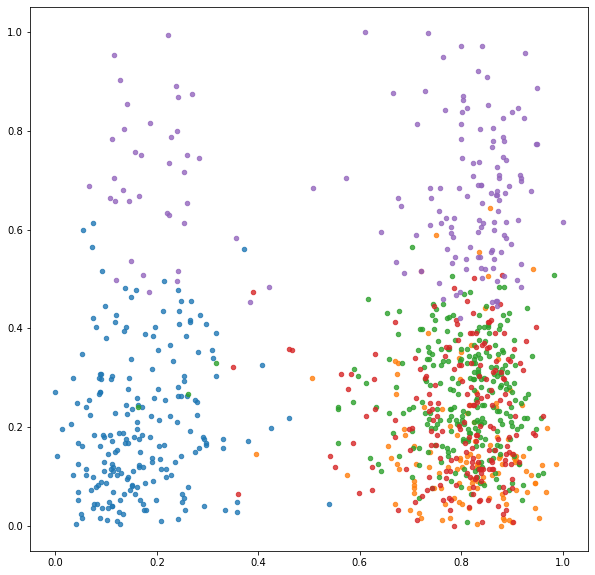

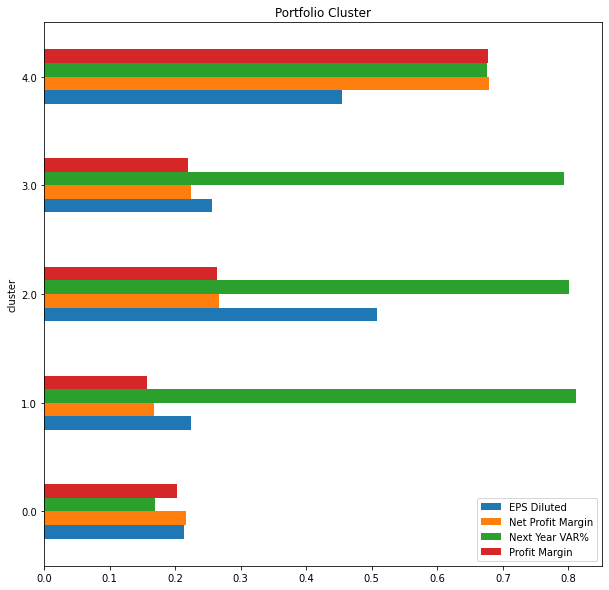

In [798]:
# Set n_cluster = 5 according to elbow method and fit ordinary X
# The result is less intuitive and not as well clustered.
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
inertia = kmeans.inertia_
print(inertia)
label_array = kmeans.predict(X)
label_array.shape

for c in set(label_array):
    print('Cluster {} has {} data points'.format(c, X[kmeans.labels_ == c].shape[0]))

display_cluster(X, kmeans, num_clusters=set(label_array))
tmp_df = indicator_data.copy()
tmp_df['kmeans cluster'] = label_array
report_df = cluster_report(tmp_df)
report_df.set_index('cluster', inplace=True, drop=True)
report_df.plot(kind='barh', figsize=(10,10), title='Portfolio Cluster')

### Mean - shift
Through different bandwidth (KDE) to see the behavior of clustering.

,quantile,bandwidth,silhouette_score,calinski_harabasz_score
0,0.05,0.183865,0.231244,336.128882
1,0.06,0.200607,0.266049,361.490871
2,0.07,0.217754,0.239208,275.105603
3,0.08,0.232079,0.263562,312.237537
4,0.09,0.245833,0.263808,311.547856


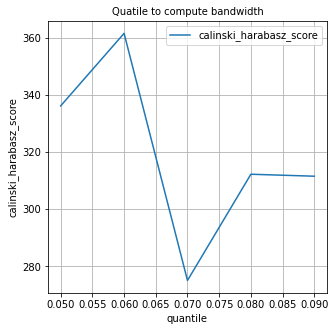

In [799]:
# quantile from 0.05 to 0.1
# over 0.1 will cause less meaningful cluster
df = pd.DataFrame()
for q in range(5, 10):
    bandwidth = estimate_bandwidth(PCA_X, quantile=(q/100))
    model = MeanShift(bandwidth = bandwidth, bin_seeding = True)
    model.fit(PCA_X)
    labels = model.predict(PCA_X)
    s = pd.Series({'quantile':q/100,
                   'bandwidth': bandwidth,
                   'silhouette_score':silhouette_score(PCA_X, labels),
                   'calinski_harabasz_score':calinski_harabasz_score(PCA_X, labels)
                  })
    df = df.append(s, ignore_index=True)
df = df[['quantile', 'bandwidth', 'silhouette_score', 'calinski_harabasz_score']]
df

# ax = df.plot(kind='line', x='quantile', y='silhouette_score', figsize=(5,5), grid=True)
ax = df.plot(kind='line', x='quantile', y='calinski_harabasz_score', figsize=(5,5), grid=True)
ax.set_title('Quatile to compute bandwidth', fontsize=10)
ax.set_xlabel('quantile', fontsize=10)
ax.set_ylabel('calinski_harabasz_score', fontsize=10)
# ax.set_xticks(range(0,50,5))
ax.legend(fontsize=10)
df

Cluster 0 has 276 data points
Cluster 1 has 221 data points
Cluster 2 has 138 data points
Cluster 3 has 75 data points
Cluster 4 has 107 data points
Cluster 5 has 31 data points
Cluster 6 has 18 data points
Cluster 7 has 17 data points
Cluster 8 has 2 data points
Cluster 9 has 8 data points
Cluster 10 has 19 data points
Cluster 11 has 18 data points


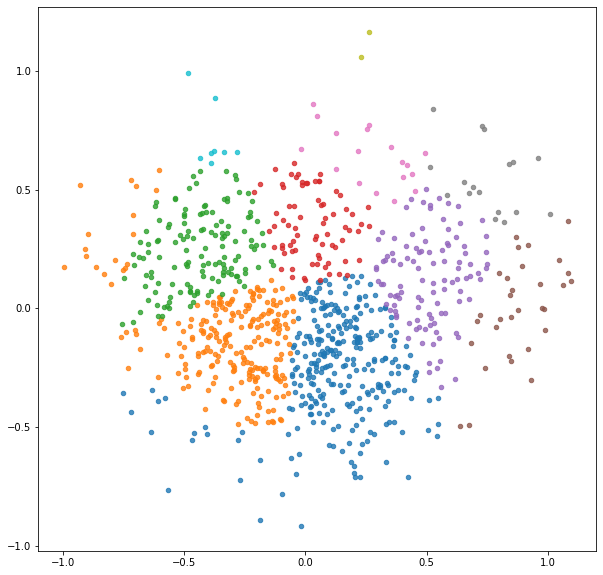

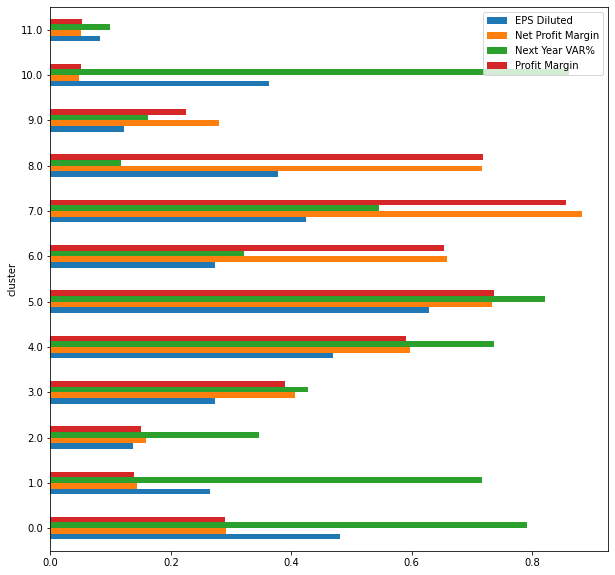

In [800]:
#estimate bandwidth:: loop in 
bandwidth = estimate_bandwidth(PCA_X, quantile=0.06)
#Mean Shift method
model = MeanShift(bandwidth = bandwidth, bin_seeding = True)
model.fit(PCA_X)
labels = model.predict(PCA_X)
cluster_num = len(set(labels))
for c in set(labels):
    print('Cluster {} has {} data points'.format(c, PCA_X[model.labels_ == c].shape[0]))
display_cluster(PCA_X, model, num_clusters=set(labels))

tmp_df = indicator_data.copy()
tmp_df['mean shift cluster'] = labels
report_df = cluster_report(tmp_df, n_cluster=range(0, cluster_num), key_column='mean shift cluster')
report_df.set_index('cluster', inplace=True, drop=True)
report_df.plot(kind='barh', figsize=(10,10))

c_df = c_df.append(add_result('MeanShift', labels), ignore_index=True)

The bandwidth is 0.7423146290413821
Cluster 0 has 879 data points
Cluster 1 has 3 data points
Cluster 2 has 9 data points
Cluster 3 has 18 data points
Cluster 4 has 21 data points


<AxesSubplot:ylabel='cluster'>

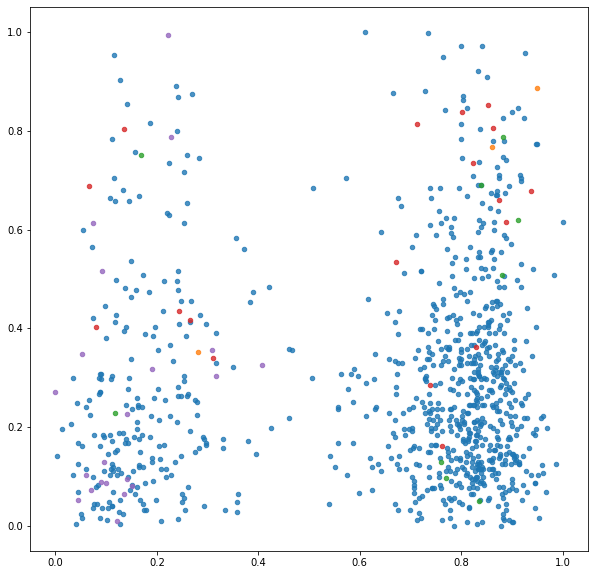

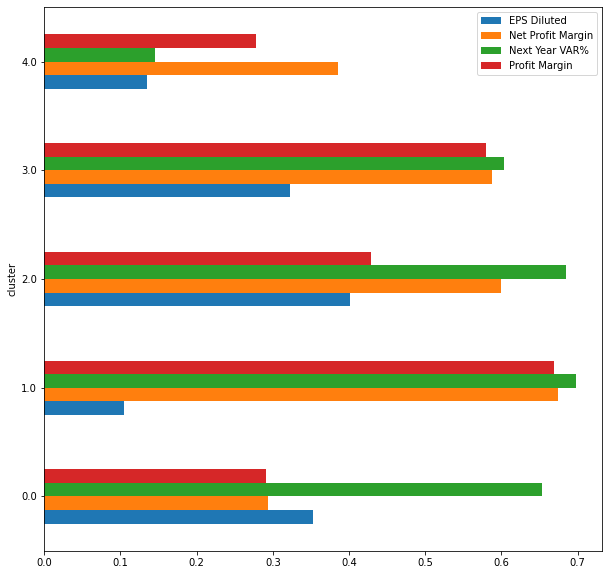

In [801]:
#estimate bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.06)
print('The bandwidth is {}'.format(bandwidth))
#Mean Shift method
model = MeanShift(bandwidth = bandwidth, bin_seeding = True)
model.fit(X)
labels = model.predict(X)
cluster_num = len(set(labels))
for c in set(labels):
    print('Cluster {} has {} data points'.format(c, X[model.labels_ == c].shape[0]))
display_cluster(X, model, num_clusters=set(labels))

tmp_df = indicator_data.copy()
tmp_df['mean shift cluster'] = labels
report_df = cluster_report(tmp_df, n_cluster=range(0, cluster_num), key_column='mean shift cluster')
report_df.set_index('cluster', inplace=True, drop=True)
report_df.plot(kind='barh', figsize=(10,10))

### Hierarchical clustering (HCA) 
With ward, complete and average linkage

In [802]:
def plot_hca(model, method):
    Z = hierarchy.linkage(agglo_ward.children_, method=method)

    fig, ax = plt.subplots(figsize=(15,5))

    # Some color setup
    red = colors[2]
    blue = colors[0]

    hierarchy.set_link_color_palette([red, 'gray'])
    ax.set_title(method, fontsize=12)
    den = hierarchy.dendrogram(Z, orientation='top', 
                               p=30, truncate_mode='lastp',
                               show_leaf_counts=True, ax=ax,
                               above_threshold_color=blue)

In [803]:
# Find out the optimal cluster number for HCA
linkages = ['ward', 'single', 'complete', 'average']
metrics_df = pd.DataFrame()
for cluster in range(2,11):
    for linkage in linkages:
        agglo_ = AgglomerativeClustering(n_clusters=cluster, linkage=linkage, compute_full_tree=True)
        agglo_.fit(PCA_X)
        agglo_labels = agglo_.fit_predict(PCA_X)
        sil_score = silhouette_score(PCA_X, agglo_labels)
        calin_score = calinski_harabasz_score(PCA_X, agglo_labels)
        s = pd.Series({'n_cluster':cluster,
                       'linkage': linkage,
                       'silhouette_score':sil_score,
                      'calinski_harabasz_score':calin_score})
        metrics_df = metrics_df.append(s, ignore_index=True)
#         plot_hca(agglo_, linkage)
metrics_df = metrics_df[['n_cluster','linkage', 'silhouette_score', 'calinski_harabasz_score']]
metrics_df.sort_values(by=['silhouette_score', 'calinski_harabasz_score'], ascending=False)

,n_cluster,linkage,silhouette_score,calinski_harabasz_score
1,2.0,single,0.444177,10.291581
3,2.0,average,0.376254,416.804624
0,2.0,ward,0.347690,585.369520
4,3.0,ward,0.321414,564.160210
8,4.0,ward,0.320120,581.441453
7,3.0,average,0.313041,227.778282
12,5.0,ward,0.306365,555.823391
11,4.0,average,0.286976,354.323622
28,9.0,ward,0.283917,558.267980
24,8.0,ward,0.280083,554.615428


Cluster 0 has 327 data points
Cluster 1 has 358 data points
Cluster 2 has 149 data points
Cluster 3 has 96 data points


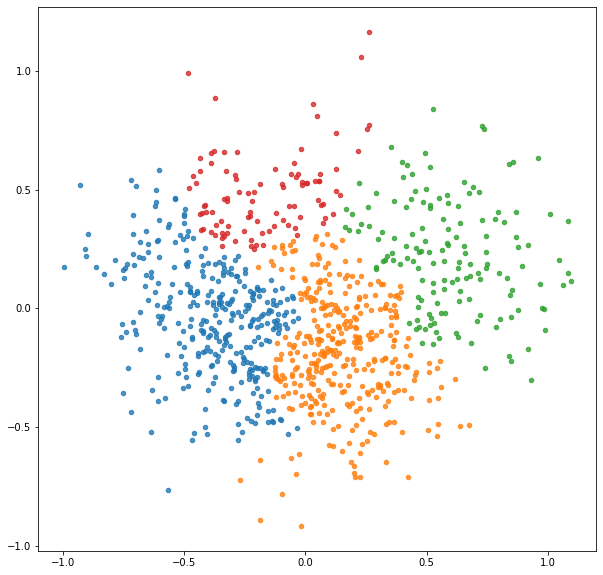

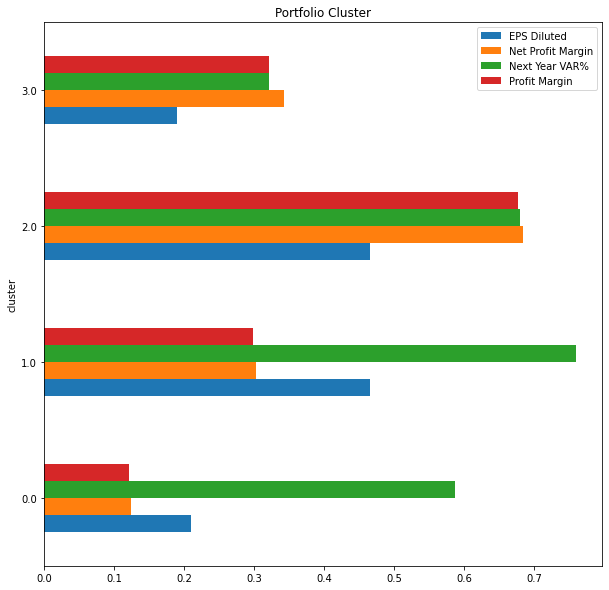

In [804]:
agglo_ = AgglomerativeClustering(n_clusters=4, linkage='ward', compute_full_tree=True)
agglo_.fit(PCA_X)
agglo_labels = agglo_.fit_predict(PCA_X)
for c in set(agglo_labels):
    print('Cluster {} has {} data points'.format(c, PCA_X[agglo_.labels_ == c].shape[0]))
display_cluster(PCA_X, agglo_, num_clusters=set(agglo_labels))

tmp_df = indicator_data.copy()
tmp_df['HCA cluster'] = agglo_labels
report_df = cluster_report(tmp_df, n_cluster=range(0,4), key_column='HCA cluster')
report_df.set_index('cluster', inplace=True, drop=True)
report_df.plot(kind='barh', figsize=(10, 10), title='Portfolio Cluster')

c_df = c_df.append(add_result('HCA', agglo_labels), ignore_index=True)

In [805]:
# Check the scoring of KMeans, MeanShifts, and HCA
c_df[['model', 'silhouette_score', 'calinski_harabasz_score']]

,model,silhouette_score,calinski_harabasz_score
0,KMeans,0.174768,392.748307
1,MeanShift,0.266049,361.490871
2,HCA,0.320120,581.441453


In [806]:
# Real data mapping
agglo_labels.shape

indicator_data['HCA Cluster'] = agglo_labels
indicator_data.shape

indicator_data.loc[(indicator_data['HCA Cluster']==1) | 
                   (indicator_data['HCA Cluster']==2)].sort_values(by=['Next Year VAR%', 
                                                                     'EPS Diluted',
                                                                     'Profit Margin',
                                                                     'Net Profit Margin'], ascending=False)

,Data Year,Stock,Class,Next Year VAR%,Profit Margin,Net Profit Margin,EPS Diluted,returnOnAssets,returnOnEquity,priceToFreeCashFlowsRatio,...,priceEarningsToGrowthRatio,assetTurnover,currentRatio,quickRatio,debtEquityRatio,Interest Coverage,Receivables Turnover,Inventory Turnover,Working Capital,HCA Cluster
638,2018,SEAC,1,1.000000,0.616309,0.615959,0.101809,0.426676,0.479847,0.447135,...,0.303284,0.321742,0.577800,0.621187,0.343449,0.077178,0.174097,0.868737,0.371577,2
364,2018,UCTT,1,0.987288,0.126646,0.125442,0.217348,0.151305,0.342320,0.581314,...,0.299696,0.503727,0.660951,0.496364,0.571129,0.492440,0.602336,0.334977,0.524751,1
404,2018,SEDG,1,0.982793,0.509070,0.509418,0.435446,0.412270,0.605489,0.465407,...,0.387576,0.444246,0.623761,0.566981,0.357310,0.893999,0.432561,0.410930,0.551525,2
612,2018,VEC,1,0.961560,0.107302,0.102925,0.471186,0.604325,0.483461,0.419306,...,0.245849,0.813042,0.376807,0.390516,0.456623,0.543030,0.406341,0.000000,0.420419,1
521,2018,BLD,1,0.957627,0.218209,0.213885,0.523240,0.554731,0.421531,0.509996,...,0.373877,0.444096,0.414073,0.344237,0.551034,0.496030,0.434591,0.519530,0.507296,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,2018,SWN,0,0.092318,0.516076,0.514690,0.215595,0.215267,0.602421,0.153677,...,0.104672,0.318869,0.320869,0.326617,0.612902,0.363547,0.479098,0.000000,0.438039,1
20,2018,X,0,0.085194,0.300334,0.296708,0.664546,0.320326,0.666253,0.000000,...,0.056391,0.555990,0.399933,0.302680,0.520342,0.379272,0.451883,0.391331,0.654813,1
906,2018,NEWA,0,0.072538,0.564779,0.564604,0.166511,0.464115,0.668568,0.000000,...,0.293660,0.360394,0.359222,0.205285,0.520291,0.619193,0.357572,0.292657,0.239322,1
200,2018,HCLP,0,0.054181,0.599207,0.599144,0.292343,0.225674,0.503047,0.277690,...,0.023465,0.282989,0.460608,0.406784,0.516601,0.474000,0.450702,0.527548,0.452141,2


array([[<AxesSubplot:title={'center':'Next Year VAR%'}>,
        <AxesSubplot:title={'center':'Profit Margin'}>,
        <AxesSubplot:title={'center':'Net Profit Margin'}>,
        <AxesSubplot:title={'center':'EPS Diluted'}>],
       [<AxesSubplot:title={'center':'returnOnAssets'}>,
        <AxesSubplot:title={'center':'returnOnEquity'}>,
        <AxesSubplot:title={'center':'priceToFreeCashFlowsRatio'}>,
        <AxesSubplot:title={'center':'priceEarningsRatio'}>],
       [<AxesSubplot:title={'center':'priceEarningsToGrowthRatio'}>,
        <AxesSubplot:title={'center':'assetTurnover'}>,
        <AxesSubplot:title={'center':'currentRatio'}>,
        <AxesSubplot:title={'center':'quickRatio'}>],
       [<AxesSubplot:title={'center':'debtEquityRatio'}>,
        <AxesSubplot:title={'center':'Interest Coverage'}>,
        <AxesSubplot:title={'center':'Receivables Turnover'}>,
        <AxesSubplot:title={'center':'Inventory Turnover'}>],
       [<AxesSubplot:title={'center':'Working Capit

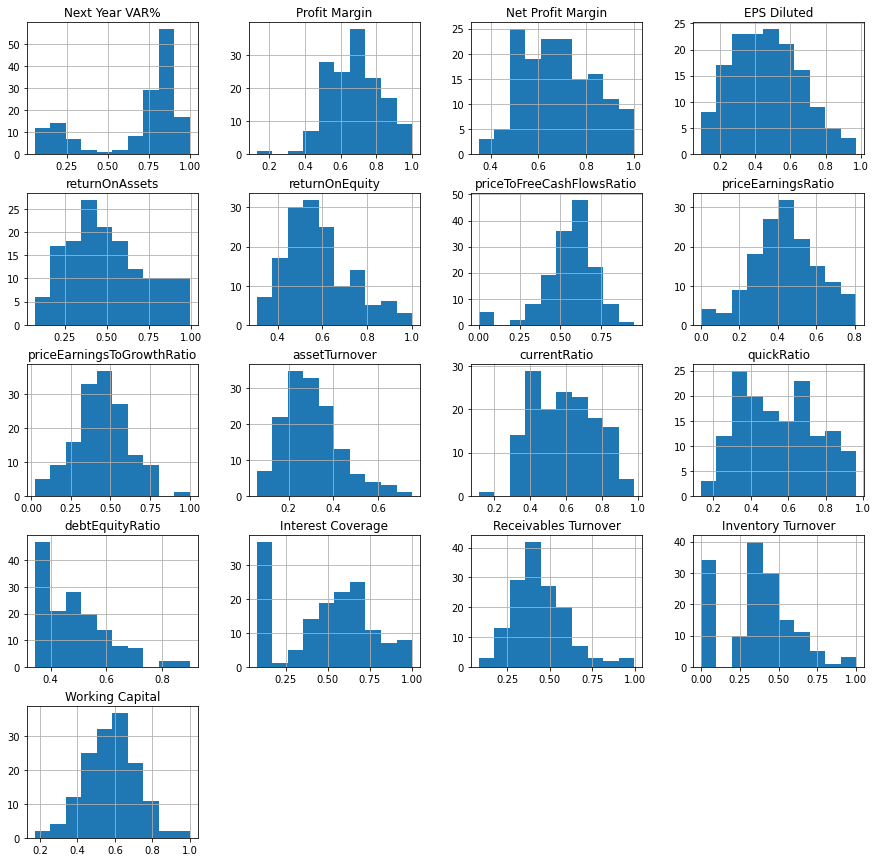

In [807]:
indicator_data.loc[(indicator_data['HCA Cluster']==2)][feature_column].hist(figsize=(15,15))

### DBScan

0.2354356675566035
Cluster 0 has 920 data points
Cluster -1 has 10 data points


<AxesSubplot:title={'center':'Portfolio Cluster'}, ylabel='cluster'>

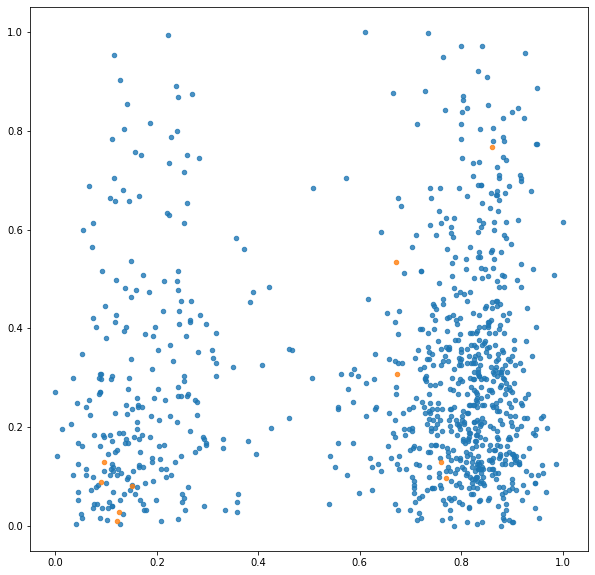

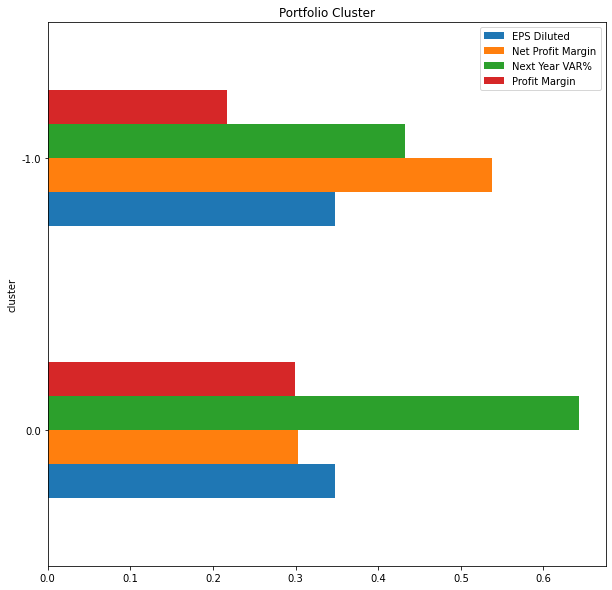

In [808]:
dbscan = DBSCAN(eps=0.8, min_samples=3, metric='euclidean')
model = dbscan.fit(X)
dbscan_labels = dbscan.fit_predict(X)
dbscan_score = silhouette_score(X, dbscan_labels)
dbscan.core_sample_indices_.shape
print(dbscan_score)
display_cluster(X, model, num_clusters=set(dbscan_labels))
for c in set(dbscan_labels):
    print('Cluster {} has {} data points'.format(c, X[model.labels_ == c].shape[0]))
tmp_df = indicator_data.copy()
tmp_df['DBScan'] = dbscan_labels
report_df = cluster_report(tmp_df, n_cluster=set(dbscan_labels), key_column='DBScan')
report_df.set_index('cluster', inplace=True, drop=True)
report_df.plot(kind='barh', figsize=(10, 10), title='Portfolio Cluster')

-0.12575760678055287
{0, 1, 2, 3, 4, 5, -1}
Cluster 0 has 872 data points
Cluster 1 has 4 data points
Cluster 2 has 3 data points
Cluster 3 has 3 data points
Cluster 4 has 3 data points
Cluster 5 has 4 data points
Cluster -1 has 41 data points


<AxesSubplot:title={'center':'Portfolio Cluster'}, ylabel='cluster'>

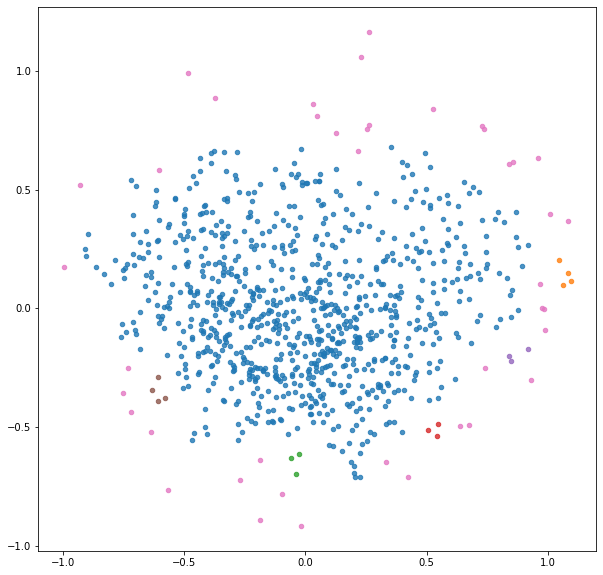

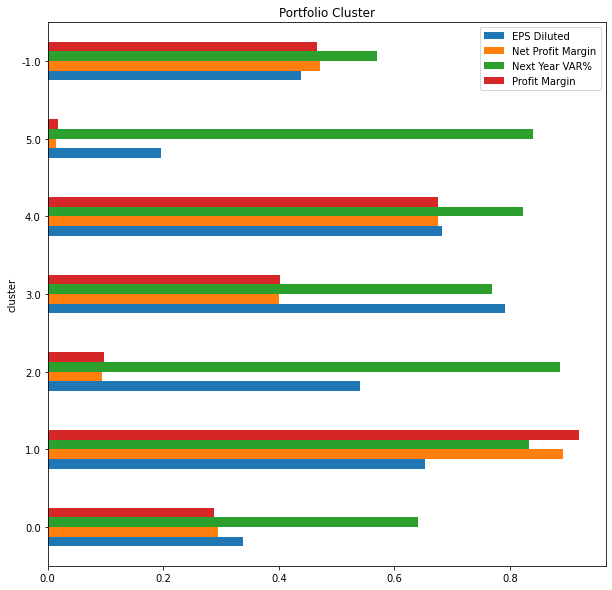

In [809]:
dbscan = DBSCAN(eps=0.085, min_samples=3, metric='euclidean')
model = dbscan.fit(PCA_X)
dbscan_labels = dbscan.fit_predict(PCA_X)
dbscan_score = silhouette_score(PCA_X, dbscan_labels)
dbscan.core_sample_indices_.shape
print(dbscan_score)
print(set(dbscan_labels))
display_cluster(PCA_X, model, num_clusters=set(dbscan_labels))
for c in set(dbscan_labels):
    print('Cluster {} has {} data points'.format(c, PCA_X[model.labels_ == c].shape[0]))
tmp_df = indicator_data.copy()
tmp_df['DBScan'] = dbscan_labels
report_df = cluster_report(tmp_df, n_cluster=set(dbscan_labels), key_column='DBScan')
report_df.set_index('cluster', inplace=True, drop=True)
report_df.plot(kind='barh', figsize=(10, 10), title='Portfolio Cluster')

### End of this notebook